# morph-var 5


## Calculate the morphologic variability of a landform by determining the number and proportion of classes present in a moving window.


In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

In [ ]:
%matplotlib qt

## Determine variability space

In [2]:
def subset_sum(numbers, target, partial=[], partial_sum=0):
    if partial_sum == target:
        yield partial
    if partial_sum >= target:
        return
    for i, n in enumerate(numbers):
        remaining = numbers[i + 1:]
        yield from subset_sum(remaining, target, partial + [n], partial_sum + n)

In [3]:
master_list=list(np.linspace(0,1,13))[1:]

In [4]:
master_list_1=[]

for a in range(0,len(master_list)-1):
    master_list_1.append(list(master_list[a]*np.ones(7)))
    
master_list_1=list(itertools.chain.from_iterable(master_list_1))
master_list_1.append(1)

In [5]:
master_df=pd.DataFrame(subset_sum(master_list_1,1)).drop_duplicates().reset_index(drop=True)
master_df['count']=master_df.count(axis=1)

In [6]:
scenarios_df=master_df[master_df['count'] <= 6].iloc[:,0:6].reset_index(drop=True).fillna(0)
scenarios_df.loc[-1]=[master_list_1[7],master_list_1[7],master_list_1[7],master_list_1[7],master_list_1[7],master_list_1[7]]
scenarios_df.index=scenarios_df.index+1
scenarios_df = scenarios_df.sort_index()

In [7]:
number_scenarios=len(scenarios_df.index)

In [8]:
number_classes = pd.DataFrame()
std_scenario_prop = pd.DataFrame()
diff_prop = pd.DataFrame()
for a in range(0,number_scenarios):
    scenario_temp = scenarios_df.iloc[a,:]
    
    number_classes_temp = len(scenario_temp[scenario_temp!=0])
    number_classes[a]= pd.Series(number_classes_temp)
    
    diff_prop_temp=scenario_temp.max()-scenario_temp[scenario_temp!=0].min()
    diff_prop[a]=pd.Series(diff_prop_temp)
    
    std_scenario_prop_temp = np.std(scenario_temp)
    std_scenario_prop[a]=pd.Series(std_scenario_prop_temp)

std_scenario_prop_norm1=std_scenario_prop.iloc[0,:].max()-std_scenario_prop+number_classes.iloc[0,:]/12
std_scenario_prop_norm2=std_scenario_prop_norm1.iloc[0,:]-std_scenario_prop_norm1.iloc[0,:].min()
std_scenario_prop_norm3= std_scenario_prop_norm2/std_scenario_prop_norm2.max()

In [9]:
variability_scenarios = pd.concat([number_classes.iloc[0,:],diff_prop.iloc[0,:],std_scenario_prop_norm3],axis=1)
variability_scenarios.columns=['Number of classes','Difference between the highest and lowest non-zero proportions','Variability metric']

In [10]:
variability_scenarios_sorted=variability_scenarios.sort_values(by=['Number of classes','Variability metric'],ascending=[True,True]).drop_duplicates().reset_index(drop=True)
variability_scenarios_sorted['Difference between the highest and lowest non-zero proportions'].iat[0]=1

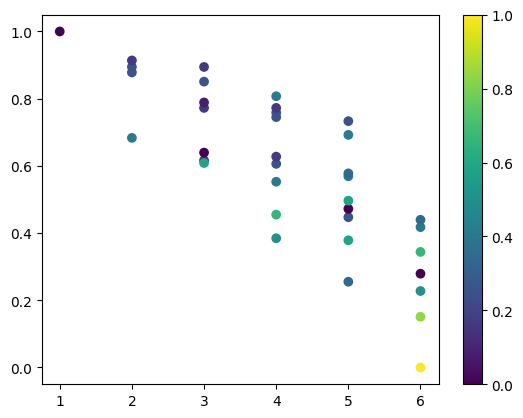

In [11]:
fig=plt.figure()
cc=plt.scatter(number_classes,variability_scenarios_sorted['Variability metric'],c=variability_scenarios_sorted['Difference between the highest and lowest non-zero proportions'],cmap='viridis')
fig.colorbar(cc)

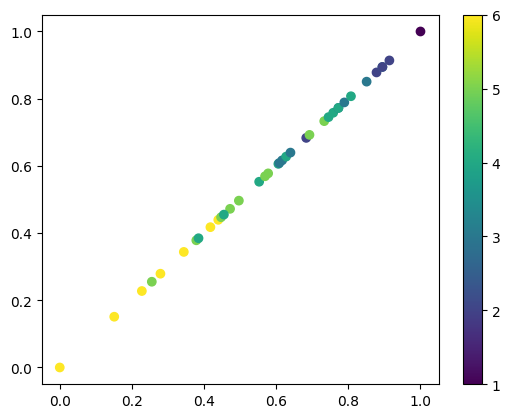

In [12]:
fig=plt.figure()
cc=plt.scatter(variability_scenarios_sorted['Variability metric'],variability_scenarios_sorted['Variability metric'],c=number_classes,cmap='viridis')
fig.colorbar(cc)

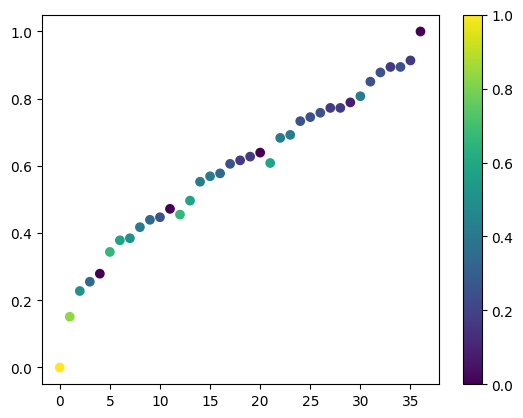

In [13]:
fig=plt.figure()
cc=plt.scatter(variability_scenarios_sorted.index,variability_scenarios_sorted['Variability metric'],c=variability_scenarios_sorted['Difference between the highest and lowest non-zero proportions'],cmap='viridis')
fig.colorbar(cc)

## Calculate along-strike variability of scarp


In [15]:
# path_pred = "../Data2/Classification_results"
# file_name ="KoaeFZ17"
# predictions=pd.read_csv(path_pred+"/"+file_name+"_prediction.txt").iloc[:,1:3]

In [ ]:
path_distance="../Data2/All_distance_filename"
distance=pd.read_csv(path_distance+"/"+file_name+"_distance_filename.txt").iloc[:,1:3]

In [ ]:
pred_distance=distance.merge(predictions,how='outer',on='filename')
predictions=pred_distance['class']
distance=pred_distance['distance']

In [ ]:
pred_distance

In [ ]:

half_window_length = 12#
window_center = list(pred_distance['class'].index)[half_window_length:len(pred_distance['class'])-half_window_length:1]#int(scarp_height/8)]
profile_step=2
scarp_length = np.array(window_center)*profile_step
position=pd.Series(range((len(pred_distance['class'])*2)))

In [ ]:
def get_class_proportions(class_name, series):
    find_class_name= series[series.index[series==class_name]]
    total_length = len(series.index)
    prop_class = len(find_class_name)/total_length
    return prop_class

In [ ]:
variability_scarp = pd.DataFrame(index=range(0,len(window_center)),columns=range(0,4))
stdev_prop=[]
n_classes=[]

for w in range(0,len(window_center)):
    
    scarp_slice = pd.DataFrame(pred_distance['class'][window_center[w]-half_window_length:window_center[w]+half_window_length], columns=['class'])
    length_scarp_slice=len(scarp_slice)
    n_classes.append(int(scarp_slice.nunique()))
    
    
    variability_scarp.iloc[w,2]=length_scarp_slice
    
    class_1_temp = get_class_proportions(1,scarp_slice['class'])
    class_2_temp = get_class_proportions(2,scarp_slice['class'])
    class_3_temp = get_class_proportions(3,scarp_slice['class'])
    class_4_temp = get_class_proportions(4,scarp_slice['class'])
    class_5_temp = get_class_proportions(5,scarp_slice['class'])
    class_6_temp = get_class_proportions(6,scarp_slice['class'])
    
    class_proportions_temp = pd.Series([class_1_temp,class_2_temp,class_3_temp,class_4_temp,class_5_temp,class_6_temp])
    
    stdev_prop.append(np.std(class_proportions_temp))
    
n_classes=pd.Series(np.array(n_classes))
stdev_prop=pd.Series(np.array(stdev_prop))

variability_temp = (std_scenario_prop.iloc[0,:].max()- stdev_prop) + n_classes/12
variability_temp = variability_temp-std_scenario_prop_norm1.iloc[0,:].min()
variability_temp = variability_temp/std_scenario_prop_norm2.max()
    
variability_scarp.iloc[:,1]=variability_temp
variability_scarp.iloc[:,0]=pred_distance['filename'][half_window_length:-half_window_length].reset_index(drop=True)
variability_scarp.iloc[:,2]=pred_distance['distance'][half_window_length:-half_window_length].reset_index(drop=True)

In [ ]:
variability_scarp

In [ ]:
fig,ax=plt.subplots()
ax.set_ylim([0,1])
ax.plot(variability_scarp.iloc[:,0],variability_scarp.iloc[:,1])
ax.set_title(file_name)

In [ ]:
mean_variability = variability_scarp.iloc[:,1].mean()

In [ ]:
fig,ax=plt.subplots()
ax.set_ylim([0,1])
ax.plot(scarp_length,variability_scarp.iloc[:,1])
ax.plot(scarp_length,np.ones(len(scarp_length))*mean_variability,':',c='coral')
ax.set_title(file_name)
ax.set_aspect(1000)
print(mean_variability)

## Save variability values

In [ ]:
path="../Data2/All_variability_values/"
#scarp_name = "Gildruholtsgja"
file = file_name+'_variability.txt'

In [ ]:
variability_scarp.to_csv(path+file)